# PSD Analysis

In [1]:
from pynwb import NWBFile
from datetime import datetime
from dateutil import tz
from pynwb.file import Subject
import numpy as np
from pynwb.behavior import SpatialSeries, Position, IntervalSeries, BehavioralEpochs
import pandas as pd
import mne
from pynwb.ecephys import ElectricalSeries, LFP
import matplotlib.pyplot as plt
from pynwb import NWBHDF5IO
# from nwbwidgets import nwb2widget
import seaborn as sns
from ndx_events import LabeledEvents, AnnotatedEventsTable, TTLs
from taini_colonies_main.src.nwb_data_retrieval_functions import *
from scipy import signal, stats
import re
import os
from scipy.stats import sem, t
from mne_connectivity import spectral_connectivity_epochs
import inspect

### Function definition

In [148]:
def nanpow2db(y):
    """ Power to dB conversion, setting bad values to nans
        Arguments:
            y (float or array-like): power
        Returns:
            ydB (float or np array): inputs converted to dB with 0s and negatives resulting in nans
    """

    if isinstance(y, int) or isinstance(y, float):
        if y == 0:
            return np.nan
        else:
            ydB = 10 * np.log10(y)
    else:
        if isinstance(y, list):  # if list, turn into array
            y = np.asarray(y)
        y = y.astype(float)  # make sure it's a float array so we can put nans in it
        y[y == 0] = np.nan
        ydB = 10 * np.log10(y)

    return ydB

def remove_bads(all_epochs, bads, channel):
    # Make a copy so doesn't modify the original
    eps = all_epochs.copy()
    bad_indexes = []
    for animal, bad_channels in bads.items():
        if channel in bad_channels:
            bad_indexes.extend(eps[eps.metadata['animal_id'] == animal].selection)

    return eps[~np.isin(eps.selection, bad_indexes)].get_data(picks=channel)

def get_params_text(func):
    def wrapper(*args, **kwargs):
        # Get the function's signature
        sig = inspect.signature(func)
        # Get the bound arguments
        bound_args = sig.bind(*args, **kwargs)
        # Prepare the text with arguments
        params_text = f"Called function {func.__name__} with:\n"
        for name, value in bound_args.arguments.items():
            # Skip the first argument (self)
            if name in ['epochs', 'ax', 'bads', 'channel', 'plot_individuals', 'save_fig', 'fig_title']:
                continue
            params_text += f"{name} = {value}\n"
        # Call the actual function and return its result
        result = func(*args, **kwargs)
        # Return the text with arguments
        return params_text, result
    return wrapper

@get_params_text
def plot_psd(epochs, channel, fmin, fmax, err_method, grouper, ymin_asterisks,
             bads={}, relative_powers=True, use_subj_mean=True, 
             exclude_noise=False, plot_individuals=False, ax=None, save_fig=False, 
             fig_title='PSD', scale_factor=1, palettes=None, bandwidth=5, **kwargs):
    '''
    Plot the Power Spectral Density (PSD) for different groups of epochs.

    Parameters:
    -----------
    epochs : mne.Epochs. The epochs containing the data.
    channel : str. The channel to plot the PSD for.
    fmin : float. Minimum frequency to include in the plot.
    fmax : float. Maximum frequency to include in the plot.
    err_method : str. Method to compute error bars ('ci' or 'sd').
    grouper : str. Column name in epochs metadata to group data by.
    bads : dict, optional. Bad channels for each subject (default is {}).
    relative_powers : bool, optional. Plot relative powers (default is True).
    use_subj_mean : bool or str, optional. Use mean PSD per subject (default is True).
    exclude_noise : bool or list, optional. Exclude noise frequency ranges (default is False).
    plot_individuals : bool, optional. Plot individual PSDs (default is False).
    ax : matplotlib.axes.Axes, optional. Axes to plot on (default is None).
    save_fig : bool, optional. Save the figure as a PDF (default is False).
    fig_title : str, optional. Title of the figure (default is 'PSD').
    scale_factor : float, optional. Scale factor for text size (default is 1).
    palettes : seaborn.palettes, optional. Color palette for plotting (default is None).
    bandwidth : float, optional. Bandwidth for multitaper PSD estimation (default is 5).
    **kwargs : dict, optional. Additional keyword arguments for statistical tests.

    Notes:
    ------
    - Uses multitaper PSD estimation.
    - Performs permutation cluster tests if there are exactly two groups.
    - Plots standard frequency bands and optionally excludes noise ranges.
    - Can plot individual PSDs with lower opacity.
    '''

    # Extract metadata
    metadata = epochs.metadata
    groups = metadata[grouper].unique()
    
    # Prepare colors
    if isinstance(palettes, dict):
        colors = [palettes[group] for group in groups]
    elif palettes:
        sns.set_palette(palettes)
        colors = sns.color_palette()
    else:
        colors = sns.color_palette('colorblind', max(len(groups), 6))

    # Ensure there are enough colors for all groups
    if len(colors) < len(groups):
        colors = sns.color_palette("hsv", len(groups))

    freq_bands = {
        r'$\delta$': (1, 4),  # Delta
        r'$\theta$': (4, 8),  # Theta
        r'$\alpha$': (8, 13),  # Alpha
        r'$\beta$': (13, 30),  # Beta
        r'$\gamma$': (30, 100)  # Gamma
    }

    epochs_ = epochs.copy()

    # Initialize plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    X = {}
    for i, group in enumerate(groups):
        # Select epochs for the current group
        group_epochs = epochs_[metadata[grouper] == group]
        
        if use_subj_mean:
            # Get subject column
            if isinstance(use_subj_mean, str):
                subject_column = use_subj_mean
            else:
                subject_column = 'animal_id'

            # Calculate PSDs per subject
            subjects = group_epochs.metadata[subject_column].unique()

            psds_subjects = []
            for subject in subjects:
                skip = False
                for animal, bad_channels in bads.items():
                    if ((channel in bad_channels) or (bad_channels == 'all')) and (animal==subject):
                        print(f'No data for {subject} in {group}')
                        skip = True
                if skip:
                    continue
                subject_epochs = group_epochs[group_epochs.metadata[subject_column] == subject]
                # print(f'Total epochs for {subject} {groups} is {subject_epochs.selection.shape[0]}')
                channel_data = remove_bads(subject_epochs, bads, channel)

                psds, freqs = mne.time_frequency.psd_array_multitaper(channel_data, fmin=fmin, fmax=fmax, sfreq=epochs.info['sfreq'], bandwidth=bandwidth, verbose=False)                
                # Compute relative power
                total_power = np.sum(psds, axis=-1)
                psds_rel = psds / total_power[:, np.newaxis]
                
                mean_psd = np.mean(psds_rel[:, 0, :], axis=0) if relative_powers else np.mean(psds[:, 0, :], axis=0)
                mean_psd = nanpow2db(mean_psd)  # Convert power to dB
                
                psds_subjects.append(mean_psd)
            X[group] = (psds_subjects)
            # Average PSDs across subjects
            mean_psd = np.mean(psds_subjects, axis=0)

            # Compute error #psds_subjects instead of mean_psd
            if err_method == 'ci':
                err = 1.96 * np.std(psds_subjects, axis=0) / np.sqrt(len(psds_subjects))
            elif err_method == 'sd':    
                err = np.std(psds_subjects, axis=0) 
        else:
            
            channel_data = remove_bads(group_epochs, bads, channel)

            psds, freqs = mne.time_frequency.psd_array_multitaper(channel_data, fmin=fmin, fmax=fmax, sfreq=epochs.info['sfreq'], bandwidth=bandwidth, verbose=False)
            
            # Compute relative power
            total_power = np.sum(psds, axis=-1)
            psds_rel = psds / total_power[:, np.newaxis]
            
            mean_psd = np.mean(psds_rel[:, 0, :], axis=0) if relative_powers else np.mean(psds[:, 0, :], axis=0)
            std_psd = np.std(nanpow2db(psds_rel[:, 0, :]), axis=0) if relative_powers else np.std(nanpow2db(psds[:, 0, :]), axis=0)
            mean_psd = nanpow2db(mean_psd)  # Convert power to dB

            X[group] = nanpow2db(psds_rel[:, 0, :]) if relative_powers else nanpow2db(psds[:, 0, :])
            # Compute error
            if err_method == 'ci':
                err = 1.96 * std_psd / np.sqrt(psds.shape[0])
            elif err_method == 'sd':
                err = std_psd

        # Exclude noise
        if exclude_noise:
            if isinstance(exclude_noise, (list, tuple)) and len(exclude_noise) == 2:
                freqs_to_exclude = exclude_noise
            else:
                print('No valid range to exclude provided. Default range will be used (45-55 Hz).')
                freqs_to_exclude = [45, 55]  # Default range to exclude
            
            freqs_mask = np.logical_or(freqs < freqs_to_exclude[0], freqs > freqs_to_exclude[1])
            freqs = freqs[freqs_mask]
            mean_psd = mean_psd[freqs_mask]
            err = err[freqs_mask]
        
        if plot_individuals and use_subj_mean:
            for psd in psds_subjects:
                if exclude_noise:
                    psd = psd[freqs_mask]
                ax.plot(freqs, psd, color=colors[i], alpha=0.3)
                
        elif plot_individuals and not use_subj_mean:
            raw_psds = psds_rel if relative_powers else psds
            for psd in raw_psds:
                if exclude_noise:
                    psd = psd[freqs_mask]
                ax.plot(freqs, nanpow2db(psd[0]), color=colors[i], alpha=0.01)

        ax.plot(freqs, mean_psd, label=group, color=colors[i])
        ax.fill_between(freqs, mean_psd - err, mean_psd + err, alpha=0.2, color=colors[i])

    # Add vertical lines and labels for frequency bands
    for band, (start, end) in freq_bands.items():
        ax.axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        ax.axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        ax.text((start + end) / 2, ax.get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=10, color='black')

    ax.set_xlabel('Frequency (Hz)', fontsize = 10)
    ax.set_ylabel('Power/Frequency (dB/Hz)', fontsize =  10)
    ax.set_title(f'Average (PSD) - {channel} - {fig_title}', fontsize=12)

    # Compute and plot statistics
    if len(X) == 2:
        groups = list(X.keys())
        print(f"Performing statistical tests between {groups[0]} and {groups[1]}")
        X = [np.stack(X[groups[0]], axis=0), np.stack(X[groups[1]], axis=0)]
        
        T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, n_permutations=1000, n_jobs=1, **kwargs)

        # Plot statistics
        # ymin = ax.get_ylim()[0] * 1.05
        ymin = ymin_asterisks
        ymax = ax.get_ylim()[1] * 0.9
        x = np.linspace(fmin, fmax, len(T_obs))

        for i_c, c in enumerate(clusters):
            c = c[0]
            # print(c, cluster_p_values[i_c])
            if cluster_p_values[i_c] <= 0.001:
                ax.hlines(ymin, xmin=x[c[0]], xmax=x[c[-1]], color='black', linewidth=2)
                ax.text((x[c[0]] + x[c[-1]]) / 2, ymin*1.01, '***', horizontalalignment='center', 
                        verticalalignment='top', fontsize=16, color='black')
            elif cluster_p_values[i_c] <= 0.01:
                ax.hlines(ymin, xmin=x[c[0]], xmax=x[c[-1]], color='black', linewidth=2)
                ax.text((x[c[0]] + x[c[-1]]) / 2, ymin*1.01, '**', horizontalalignment='center', 
                        verticalalignment='top', fontsize=16, color='black')
            elif cluster_p_values[i_c] <= 0.05:
                ax.hlines(ymin, xmin=x[c[0]], xmax=x[c[-1]], color='black', linewidth=2)
                ax.text((x[c[0]] + x[c[-1]]) / 2, ymin*1.01, '*', horizontalalignment='center', 
                        verticalalignment='top', fontsize=16, color='black')
    else:
        print('Statistics not computed. X needs to be exactly two observations.')


    #___________________________
    
    # ax.legend(loc='upper right', bbox_to_anchor=(1, 1))
    # legend
    if isinstance(palettes, dict):
        handles, labels = ax.get_legend_handles_labels()
        order = list(palettes.keys())
        ordered_handles = [handles[labels.index(key)] for key in order if key in labels]
        ordered_labels = [key for key in order if key in labels]
        ax.legend(ordered_handles, ordered_labels, loc='upper right', bbox_to_anchor=(1, 1))
    else:
        ax.legend(loc='upper right', bbox_to_anchor=(1, 1))
        

    for text_obj in plt.findobj(match=plt.Text):
        text_obj.set_fontsize(text_obj.get_fontsize() * scale_factor)
    if save_fig and ax is None:
        plt.savefig(f'plots/PSD_{fig_title}_{channel}.pdf')
    elif not save_fig and ax is None:
        plt.show()
    
# plot_psd(epochs_sub, "OFC_L", 0, 100, 'ci', 'genotype', exclude_noise=[47, 53], bads = bads, use_subj_mean=True, plot_individuals=True, relative_powers=True, bandwidth=3, verbose=False)
# plt.tight_layout()

### Epoch preparation functions:


In [70]:
# Function to process epochs for a behavior type
def process_epochs(behavior_name, exclusions=None):
    """
    Processes epochs for a behavior type. Gets the epoch files, cluster files and combines them to select the right epochs
    
    Parameters:
    behavior_name (str): The name of the behavior type ('Sniff', 'Approach', or 'Contact').
    exclusions (list of str): List of animal IDs to be excluded.
    
    Returns: 
    mne.Epochs: The processed epochs with updated metadata and selected cluster label.
    """
    # Define file paths
    epoch_file = f'epochs/concatenated/concat_social_{behavior_name.lower()}-epo.fif'
    cluster_file = f'feature_dfs/features_Social_{behavior_name}_clusters.xlsx'
    
    # Load epochs and the excel with clustering results
    epochs = mne.read_epochs(epoch_file)
    clusters = pd.read_excel(cluster_file)

    # Update metadata with clustering results
    epochs.metadata = pd.concat([epochs.metadata, clusters], axis=1)
    
    # Extract epochs where cluster label is 0 (== good epochs)
    epochs = epochs[clusters['clusters_label'] == 0]
    
    # Exclude specified animals
    if exclusions:
        exclusions_set = set(exclusions)
        epochs = epochs[~epochs.metadata['animal_id'].isin(exclusions_set)]
    
    # Change A/B to CNO/Saline in the 'injection' column 
    # coded for P8 B2! # TODO: make a check for batch number
    epochs.metadata['injection'] = epochs.metadata['injection'].replace({'A': 'CNO', 'B': 'Saline'})
    
    return epochs

# Function to filter the epochs (duration after injection)
def filter_by_time_minutes(df, start_min, end_min, frame_rate=30):
    start_frame = start_min * 60 * frame_rate
    end_frame = end_min * 60 * frame_rate
    return df[(df.metadata['beh_start_frame'] > start_frame) & (df.metadata['beh_start_frame'] < end_frame)]


### Main

In [ ]:
"""
p8 batch1:
A - saline
B - CNO

p8 batch2:
A - CNO
B - saline

IMPORTANT: if adding batch 1, make sure that CNO/Saline assignment is correct. 
The current code only takes into account batch 2 (coded into the process_epoch function)
"""

In [95]:
# Custom colors for plotting
custom_palette = {
            'CNO' : '#a5275e',  #red
            'Saline' : '#118691', #blue            
            }

In [112]:
# Select behavior type and exclusions
behavior_name = 'Contact'  # Change to 'Sniff, 'Approach' or 'Contact' as needed
exclusions = ['8.10', '8.16']  # List of animals to be excluded

# Process selected behavior
epochs_sub = process_epochs(behavior_name, exclusions)

# For the contact behavior, exclude the large durations of contact (bc this is sleep) 
# Limits for contact duration
cont_dur_lower = 30  # 1 second in frames
cont_dur_upper = 150  # 5 seconds in frames

if behavior_name == 'Contact':
    epochs_sub = epochs_sub[
    (epochs_sub.metadata["beh_dur_frame"] > cont_dur_lower)
    & (epochs_sub.metadata["beh_dur_frame"] < cont_dur_upper)
] 
    
# Define time limits for filtering
start_time_min = 30 # in minutes
duration_min = 2*60  # in minutes

# Filter all epochs by start and endtime (duration after injection)
epochs_sub = filter_by_time_minutes(epochs_sub, start_time_min, start_time_min + duration_min)

Reading c:\Users\lisan\OneDrive\Bureaublad\RP\EEG_acute_colonies\epochs\concatenated\concat_social_contact-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    1998.67 ms
        0 CTF compensation matrices available
Adding metadata with 19 columns
8377 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 80 columns


In [149]:
# Check if all the combinations are present and how many epochs
epochs_sub.metadata[['animal_id', 'injection']].value_counts()

animal_id  injection
8.11       Saline       101
           CNO           70
8.9        CNO           70
8.14       Saline        58
8.9        Saline        57
8.12       CNO           47
8.14       CNO           41
8.15       CNO           30
8.12       Saline        28
8.15       Saline        23
8.13       Saline        16
           CNO           14
Name: count, dtype: int64

In [146]:
# Load either DREADDs or mCherry
# surgery_type = 'DREADDs'
surgery_type = 'mCherry'

# Subset surgery and grouping value
epochs_sub_surgery = epochs_sub[epochs_sub.metadata['surgery']==surgery_type]
grouper = 'injection'

### PSD plots

Performing statistical tests between A and B


C:\Users\lisan\AppData\Local\Temp\ipykernel_13164\625450668.py:232: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, n_permutations=1000, n_jobs=1, **kwargs)
C:\Users\lisan\AppData\Local\Temp\ipykernel_13164\625450668.py:232: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, n_permutations=1000, n_jobs=1, **kwargs)


("Called function plot_psd with:\nfmin = 0\nfmax = 100\nerr_method = ci\ngrouper = injection\nymin_asterisks = -15\nrelative_powers = True\nuse_subj_mean = True\nexclude_noise = [47, 55]\npalettes = {'A': '#a5275e', 'B': '#118691'}\nbandwidth = 3\nkwargs = {'verbose': False}\n",
 None)

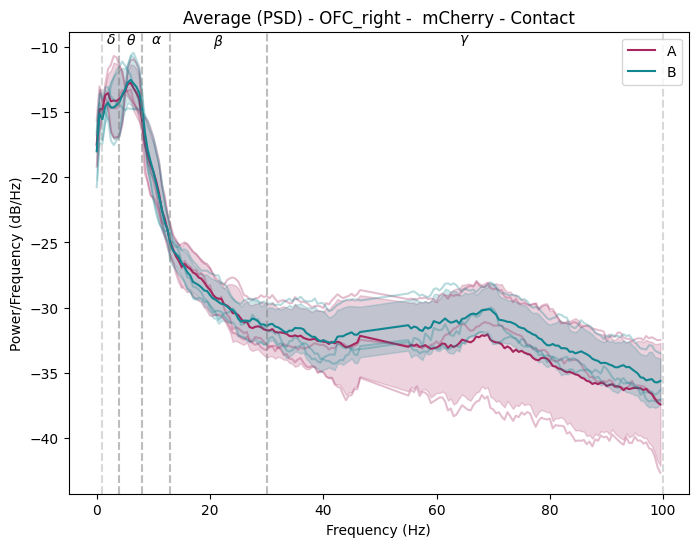

In [39]:
# define channel to look at
channel = "OFC_right"

# Plot individual channel
plot_psd(epochs_sub_surgery, 
        channel,
        0, 100, 'ci', 
        grouper=grouper, 
        exclude_noise=[47, 55], 
        use_subj_mean=True,    
        ymin_asterisks=-15,
        plot_individuals=True, 
        relative_powers=True, 
        fig_title=f' {surgery_type} - {behavior_name}', 
        palettes=custom_palette, 
        bandwidth=3, 
        verbose=False
        )


Performing statistical tests between CNO and Saline


C:\Users\lisan\AppData\Local\Temp\ipykernel_13164\18820971.py:233: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, n_permutations=1000, n_jobs=1, **kwargs)


Performing statistical tests between CNO and Saline


C:\Users\lisan\AppData\Local\Temp\ipykernel_13164\18820971.py:233: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, n_permutations=1000, n_jobs=1, **kwargs)


Performing statistical tests between CNO and Saline


C:\Users\lisan\AppData\Local\Temp\ipykernel_13164\18820971.py:233: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, n_permutations=1000, n_jobs=1, **kwargs)


Performing statistical tests between CNO and Saline


C:\Users\lisan\AppData\Local\Temp\ipykernel_13164\18820971.py:233: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, n_permutations=1000, n_jobs=1, **kwargs)


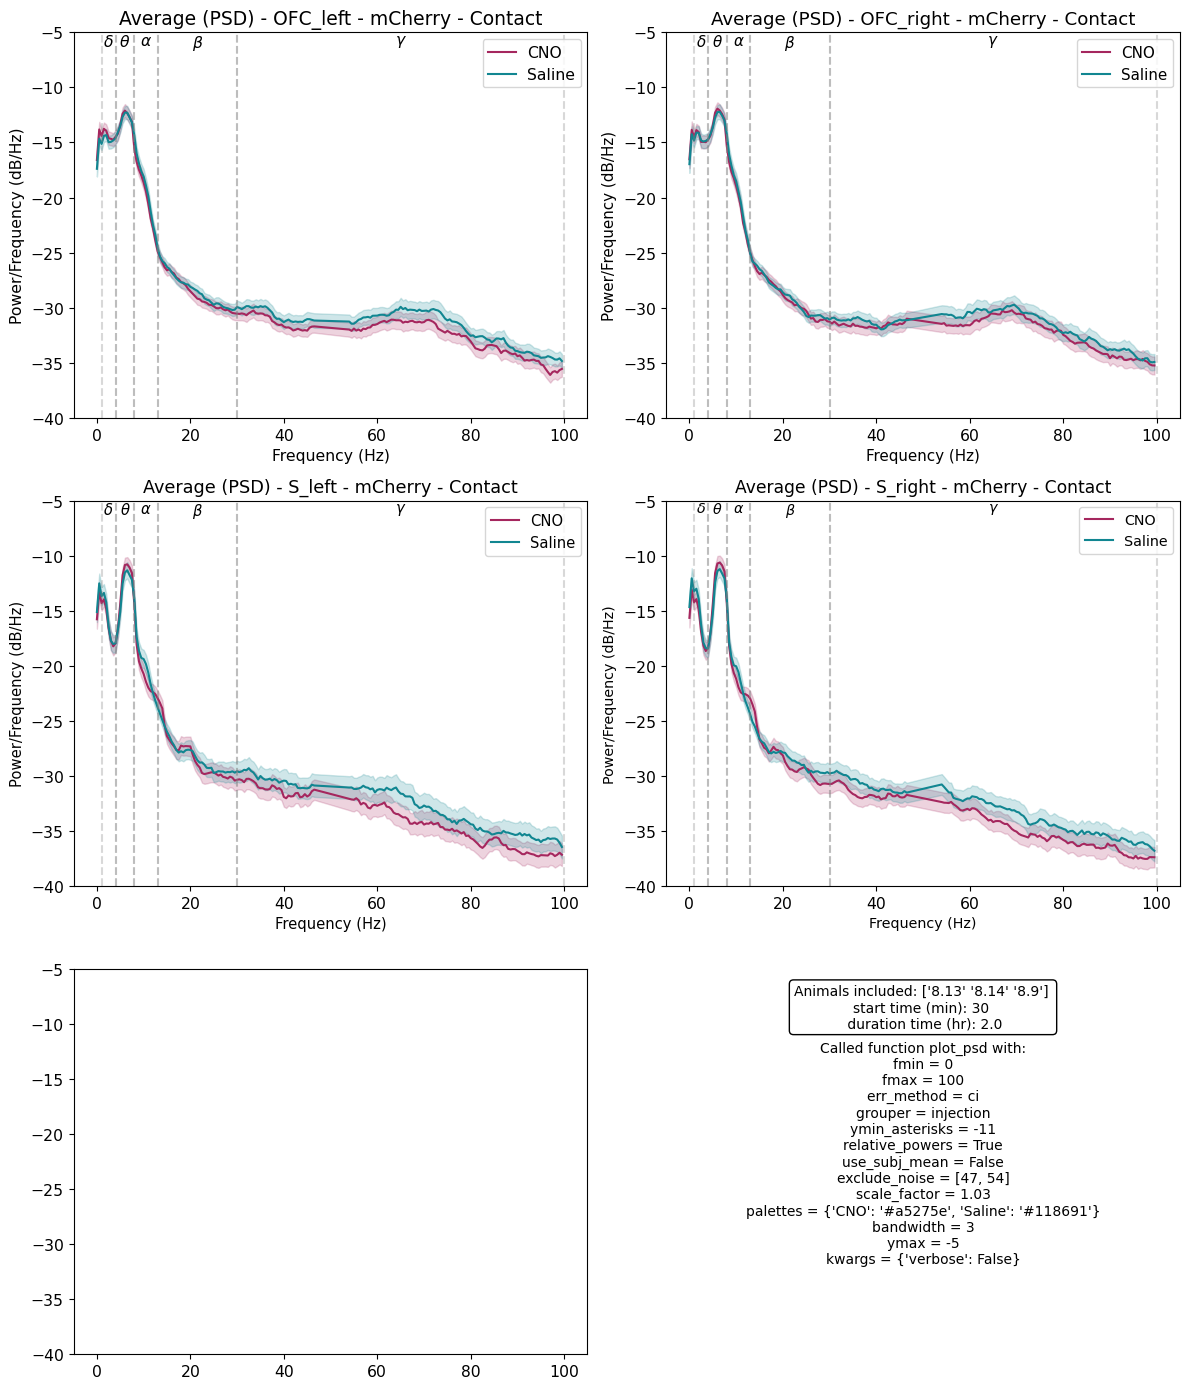

In [147]:
# Define name of output file, and included channels
outname = f'p8_b2_PSD_{surgery_type}_{behavior_name}_start{start_time_min}_dur{duration_min}_with-stats'
channels = ['OFC_left', 'OFC_right', 'S_left', 'S_right']
animal_ids = epochs_sub_surgery.metadata[['animal_id']].drop_duplicates()['animal_id'].values

# Plot
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(12, 14), sharey=True, sharex=True)
ax = ax.ravel()

for i, channel in enumerate(channels):
    out = plot_psd(
        epochs=epochs_sub_surgery,
        channel=channel,
        fmin=0,
        fmax=100,
        err_method='ci',
        grouper=grouper,
        ymin_asterisks=-11,
        relative_powers=True,
        use_subj_mean=False,
        exclude_noise=[47, 54],
        plot_individuals=False,
        ax=ax[i],
        save_fig=False,
        fig_title=f'{surgery_type} - {behavior_name}',
        palettes=custom_palette,
        bandwidth=3,
        verbose=False,
        scale_factor=1.03,
        ymax = -5
    )
    ax[i].tick_params(labelleft=True, labelbottom=True) 
    
    # Enlarge y-lim for contact limits.
    if behavior_name == 'Contact': 
        ax[i].set_ylim(-40, -5)  

# Adding annotation to the last subplot
ax[-1].annotate(f"Animals included: {animal_ids} \nstart time (min): {start_time_min} \n duration time (hr): {duration_min/60}", 
                xy=(0.5, 0.9), xycoords='axes fraction',
                ha='center', va='center',
                fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

ax[-1].axis('off')
ax[-1].text(0.5, 0.5, out[0], fontsize=10, ha='center', va='center', wrap=True, transform=ax[-1].transAxes)

plt.tight_layout()
os.makedirs(f'plots/psd/{behavior_name}', exist_ok=True)
plt.savefig(f'plots/psd/{behavior_name}/{outname}.pdf')
plt.savefig(f'plots/psd/{behavior_name}/{outname}.png')
# plt.show()

No data for 81167 in DRD2-WT
No data for 80108 in DRD2-WT
No data for 81193 in DRD2-KO
No data for 39489 in DRD2-KO
Performing statistical tests between DRD2-WT and DRD2-KO


C:\Users\basil\AppData\Local\Temp\ipykernel_36764\2818816911.py:189: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, n_permutations=1000, n_jobs=1, **kwargs)
C:\Users\basil\AppData\Local\Temp\ipykernel_36764\2818816911.py:189: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, n_permutations=1000, n_jobs=1, **kwargs)


No data for 81167 in DRD2-WT
No data for 80108 in DRD2-WT
No data for 81193 in DRD2-KO
No data for 80625 in DRD2-KO
Performing statistical tests between DRD2-WT and DRD2-KO


C:\Users\basil\AppData\Local\Temp\ipykernel_36764\2818816911.py:189: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, n_permutations=1000, n_jobs=1, **kwargs)


No data for 81167 in DRD2-WT
No data for 80108 in DRD2-WT
Performing statistical tests between DRD2-WT and DRD2-KO


C:\Users\basil\AppData\Local\Temp\ipykernel_36764\2818816911.py:189: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, n_permutations=1000, n_jobs=1, **kwargs)
C:\Users\basil\AppData\Local\Temp\ipykernel_36764\2818816911.py:189: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, n_permutations=1000, n_jobs=1, **kwargs)


No data for 81167 in DRD2-WT
No data for 80108 in DRD2-WT
Performing statistical tests between DRD2-WT and DRD2-KO


C:\Users\basil\AppData\Local\Temp\ipykernel_36764\2818816911.py:189: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, n_permutations=1000, n_jobs=1, **kwargs)
C:\Users\basil\AppData\Local\Temp\ipykernel_36764\2818816911.py:189: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, n_permutations=1000, n_jobs=1, **kwargs)


No data for 81167 in DRD2-WT
No data for 80108 in DRD2-WT
Performing statistical tests between DRD2-WT and DRD2-KO


C:\Users\basil\AppData\Local\Temp\ipykernel_36764\2818816911.py:189: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, n_permutations=1000, n_jobs=1, **kwargs)
C:\Users\basil\AppData\Local\Temp\ipykernel_36764\2818816911.py:189: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, n_permutations=1000, n_jobs=1, **kwargs)


No data for 81167 in DRD2-WT
No data for 80108 in DRD2-WT
Performing statistical tests between DRD2-WT and DRD2-KO


C:\Users\basil\AppData\Local\Temp\ipykernel_36764\2818816911.py:189: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, n_permutations=1000, n_jobs=1, **kwargs)
C:\Users\basil\AppData\Local\Temp\ipykernel_36764\2818816911.py:189: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, n_permutations=1000, n_jobs=1, **kwargs)


No data for 81167 in DRD2-WT
No data for 80108 in DRD2-WT
Performing statistical tests between DRD2-WT and DRD2-KO


C:\Users\basil\AppData\Local\Temp\ipykernel_36764\2818816911.py:189: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, n_permutations=1000, n_jobs=1, **kwargs)
C:\Users\basil\AppData\Local\Temp\ipykernel_36764\2818816911.py:189: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, n_permutations=1000, n_jobs=1, **kwargs)


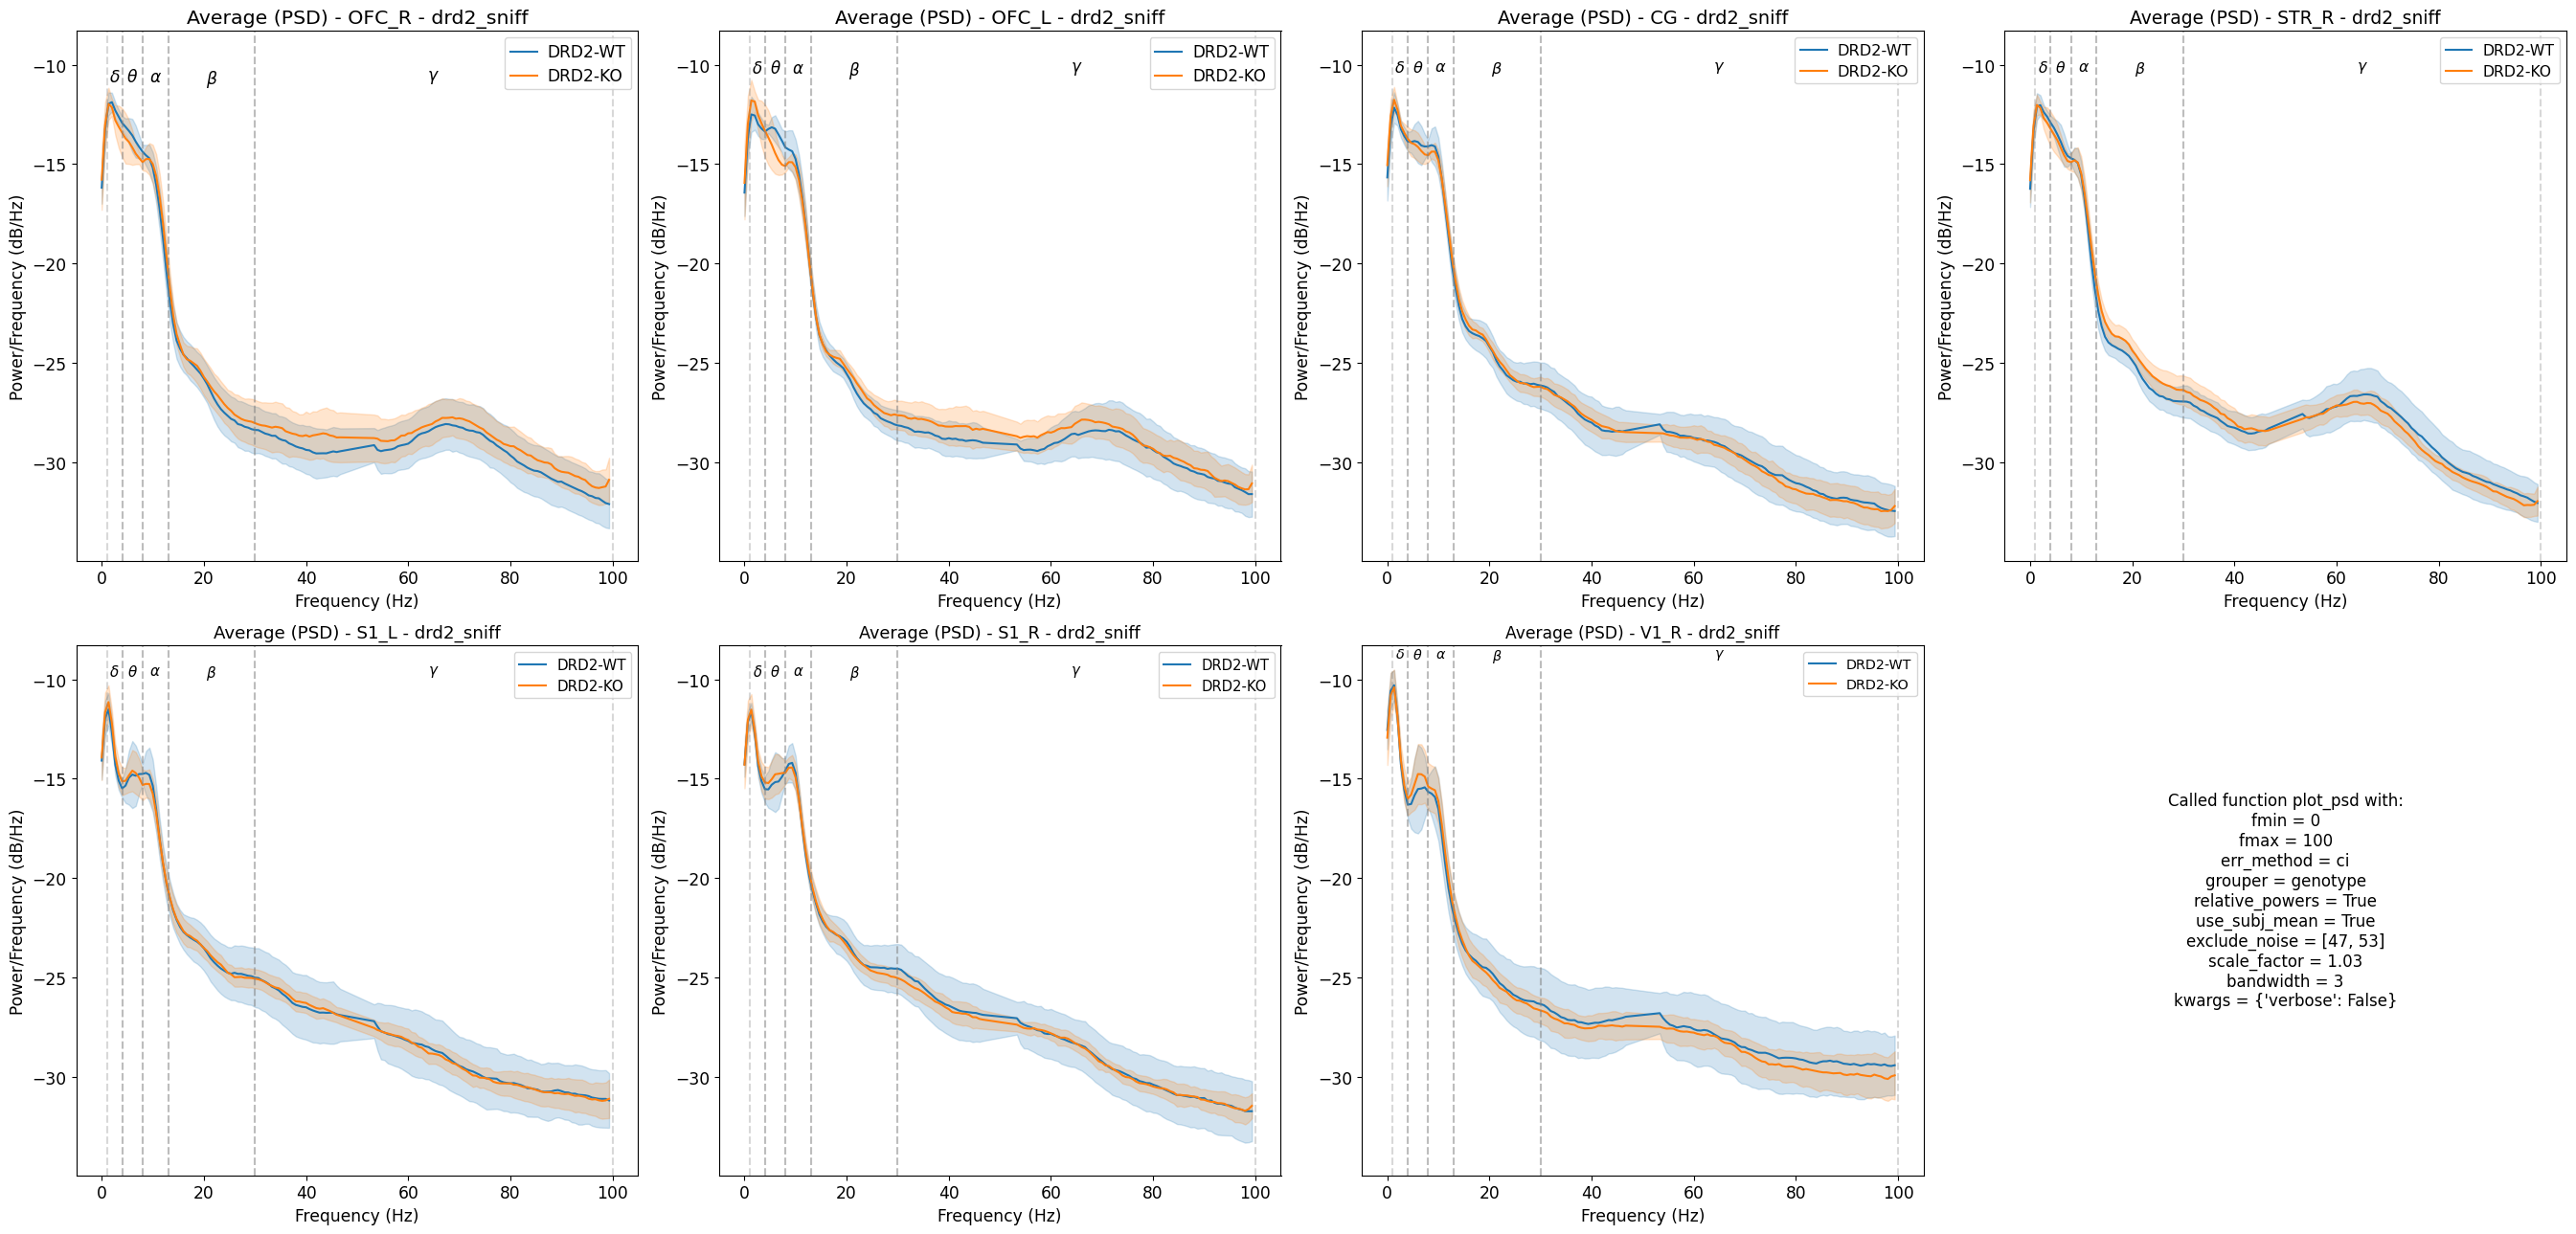

In [12]:
# VAS code
outname = 'social-approaches_drd2_with-stats'
channels = ['OFC_R', 'OFC_L', 'CG', 'STR_R', 'S1_L', 'S1_R', 'V1_R']
bads = {'39489': ["OFC_R"],
        '80625': ["OFC_L"],
        '81193': ["OFC_R", "OFC_L"],
        # '80108': ["OFC_L"],
        '80108': 'all',
        '81167': 'all'}

fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(27, 13), sharey=True, sharex=True)
ax = ax.ravel()

for i, channel in enumerate(channels):
    out = plot_psd(
        epochs=epochs_sub,
        channel=channel,
        fmin=0,
        fmax=100,
        err_method='ci',
        grouper='genotype',
        bads=bads,
        relative_powers=True,
        use_subj_mean=True,
        exclude_noise=[47, 53],
        plot_individuals=False,
        ax=ax[i],
        save_fig=False,
        fig_title='drd2_sniff',
        bandwidth=3,
        verbose=False,
        scale_factor=1.03
    )
    ax[i].tick_params(labelleft=True, labelbottom=True)  

ax[-1].axis('off')
ax[-1].text(0.5, 0.5, out[0], fontsize=12, ha='center', va='center', wrap=True, transform=ax[-1].transAxes)
plt.tight_layout()
plt.savefig(f'plots/{outname}.pdf')

X = [np.stack(out[1]['DRD2-WT'], axis=0), np.stack(out[1]['DRD2-KO'], axis=0)]

### Gamma psd average, per timebin, per channel

The code below is part of an experimental analysis, but was not functional or promising in the end.

Relative PSD

In [221]:
epochs_dir = 'epochs\concatenated'

# Define 
channels = ['OFC_left', 'OFC_right', 'S_left', 'S_right']

# Define boundaries for gamma waves
fmin = 30
fmax = 100

for filename in os.listdir(epochs_dir):
# Calculate relative psd 
   file_path = os.path.join(epochs_dir, filename)
   # Read epochs from the file
   epochs = mne.read_epochs(file_path, preload=True)   
   sfreq = epochs.info['sfreq']       
        
   for channel in channels:
      # Calculate the PSD for all datasets  
      psds, freqs = mne.time_frequency.psd_array_multitaper(epochs.get_data(channel), fmin=fmin, fmax=fmax, sfreq=sfreq)

      # Calculate total power, relative PSD and mean relative PSD
      total_power = np.sum(psds, axis=-1)
      psd_rel = nanpow2db(psds / total_power[:, np.newaxis])       
      mean_psd_rel = np.mean(psd_rel[:, 0, :], axis=-1)

      # Add column to epoch.metadata
      epochs.metadata[f'Mean_PSD_rel_{channel}'] = mean_psd_rel 
      
   # Save the epochs with updated metadata
   save_path = os.path.join(epochs_dir, f'gamma_{filename}')
   epochs.save(save_path, overwrite=False)


Reading c:\Users\lisan\OneDrive\Bureaublad\RP\EEG_acute_colonies\epochs\concatenated\concat_social_approach-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...     998.42 ms
        0 CTF compensation matrices available
Adding metadata with 19 columns
936 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Reading c:\Users\lisan\OneDrive\Bureaublad\RP\EEG_acute_colonies\epochs\concatenated\concat_social_contact-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    1998.67 ms
        0 CTF compensation matrices available
Adding metadata with 19 columns
8377 matching events found
No baseline correction applied
0 projection items activated
    Us

In [222]:
# Load epochs with average gamma column on metadata 
gamma_epochs_approach = mne.read_epochs('epochs\concatenated\gamma_concat_social_approach-epo.fif')
gamma_epochs_sniff = mne.read_epochs('epochs\concatenated\gamma_concat_social_sniff-epo.fif')
gamma_epochs_contact = mne.read_epochs('epochs\concatenated\gamma_concat_social_contact-epo.fif')

# Load clustering results
clusters_approach = pd.read_excel(r"feature_dfs\features_Social_Approach_clusters.xlsx")
clusters_sniff = pd.read_excel(r"feature_dfs\features_Social_Sniff_clusters.xlsx")
clusters_contact = pd.read_excel(r"feature_dfs\features_Social_Contact_clusters.xlsx")

# Put clusters on metadata
gamma_epochs_approach.metadata = pd.concat([gamma_epochs_approach.metadata, clusters_approach], axis=1)
gamma_epochs_sniff.metadata = pd.concat([gamma_epochs_sniff.metadata, clusters_sniff], axis=1)
gamma_epochs_contact.metadata = pd.concat([gamma_epochs_contact.metadata, clusters_contact], axis=1)

# Extract epochs from clustering results
gamma_epochs_sub_approach = gamma_epochs_approach[clusters_approach['clusters_label']==0]
gamma_epochs_sub_sniff = gamma_epochs_sniff[clusters_sniff['clusters_label']==0]
gamma_epochs_sub_contact = gamma_epochs_contact[clusters_contact['clusters_label']==0]


Reading c:\Users\lisan\OneDrive\Bureaublad\RP\EEG_acute_colonies\epochs\concatenated\gamma_concat_social_approach-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...     998.42 ms
        0 CTF compensation matrices available
Adding metadata with 23 columns
936 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\lisan\OneDrive\Bureaublad\RP\EEG_acute_colonies\epochs\concatenated\gamma_concat_social_sniff-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...     498.75 ms
        0 CTF compensation matrices available
Adding metadata with 23 columns
987 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\lisan\OneDrive\Bureaublad\RP\EEG_acute_colonies\epochs\concatenated\gamma_concat_social_contact-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    1998.67 ms
        0 CTF compensatio

In [245]:
# Limits for contact duration
cont_dur_lower = 30  # 1 second in frames
cont_dur_upper = 150  # 5 seconds in frames

# Filter based on the behavior duration limits
gamma_epochs_sub_approach = gamma_epochs_sub_approach[
    (gamma_epochs_sub_approach.metadata["beh_dur_frame"] > cont_dur_lower)
    & (gamma_epochs_sub_approach.metadata["beh_dur_frame"] < cont_dur_upper)
]

In [246]:
# Add columns for plotting
gamma_epochs_sub_approach.metadata["beh_start_time_minutes"] = gamma_epochs_sub_approach.metadata["beh_start_frame"] / 30 / 60
gamma_epochs_sub_sniff.metadata["beh_start_time_minutes"] = gamma_epochs_sub_sniff.metadata["beh_start_frame"] / 30 / 60
gamma_epochs_sub_contact.metadata["beh_start_time_minutes"] = gamma_epochs_sub_contact.metadata["beh_start_frame"] / 30 / 60

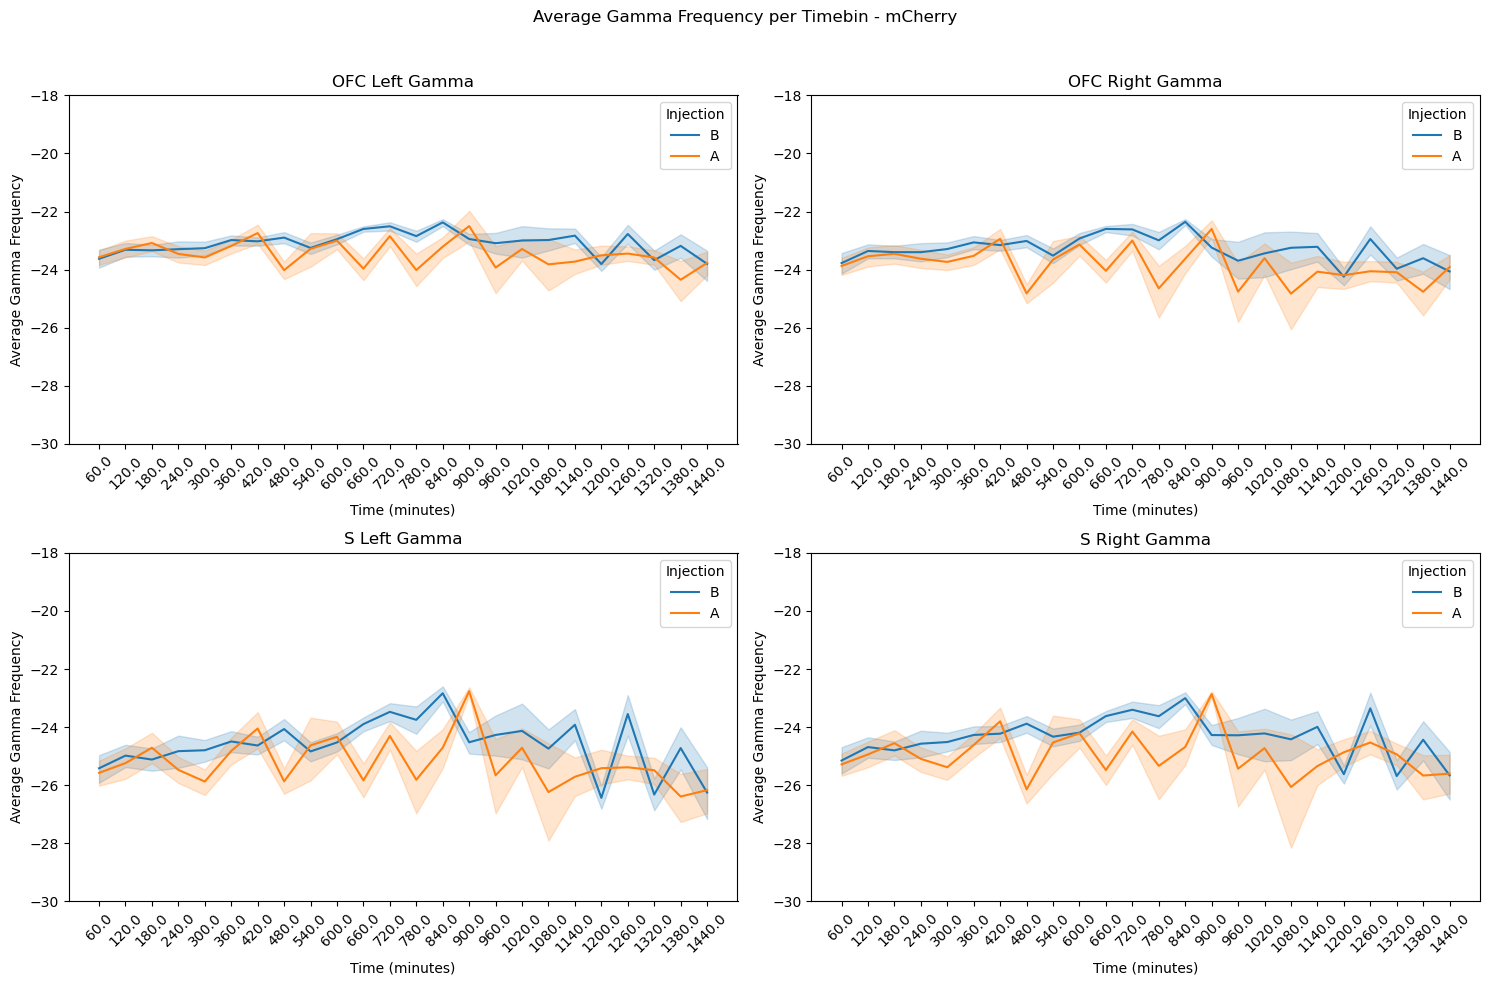

In [260]:
# Select either DREADDs or mCherry subset
surgery = "DREADDs"
# surgery = "mCherry"

ep_sub = gamma_epochs_sub_contact[gamma_epochs_sub_contact.metadata['surgery']==surgery]

# Define bin size in minutes
bin_size_minutes = 60

# Determine the maximum time in minutes to create bins
max_time_minutes = ep_sub.metadata["beh_start_time_minutes"].max()

# Create bins (starting_point, max_time, bin_length)
bins = np.arange(0, max_time_minutes + bin_size_minutes, bin_size_minutes)

# Assign each epoch to a bin
ep_sub.metadata["time_bin"] = pd.cut(
    ep_sub.metadata["beh_start_time_minutes"], bins, right=False, labels=bins[1:].astype(str)
)

rel_gamma_columns = ['Mean_PSD_rel_OFC_left', 'Mean_PSD_rel_OFC_right', 'Mean_PSD_rel_S_left', 'Mean_PSD_rel_S_right']
titles = ["OFC Left Gamma", "OFC Right Gamma", "S Left Gamma", "S Right Gamma"]

# Define surgery type
surgery_type = ep_sub.metadata['surgery'].unique()[0]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f"Average Gamma Frequency per Timebin - {surgery_type}")
axs = axs.ravel()

# Loop over each subplot
for i, (rel_gamma_columns, title) in enumerate(zip(rel_gamma_columns, titles)):
    ax = axs[i]
    sns.lineplot(data=ep_sub.metadata, x='time_bin', y=rel_gamma_columns, hue='injection', ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Time (minutes)")
    ax.set_ylabel("Average Gamma Frequency")
    ax.set_ylim(-30, -18)
    ax.legend(title=f'Injection {surgery}')
    plt.setp(ax.get_xticklabels(), rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()